This notebook demonstrates the effect of using a fine-tuning pre-trained network. It is based on a couple of other tutorials that are available online.
* [http://parneetk.github.io/blog/cnn-cifar10/](http://parneetk.github.io/blog/cnn-cifar10/)
* [https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
* [https://github.com/stratospark/food-101-keras](https://github.com/stratospark/food-101-keras)
* [https://chsasank.github.io/keras-tutorial.html](https://chsasank.github.io/keras-tutorial.html)

In [1]:
import matplotlib.pyplot as plt

import os
import time
import numpy

from keras import backend as K
K.set_image_dim_ordering('th')
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
from keras.preprocessing.image import ImageDataGenerator

C:\Users\Michal\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Next, we will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which depicts a labeled set of images beloning to 10 classes. For this tutorial, we will also reduce the size of the training set to (a) speed up training and to (b) mimic lack of labeled data.

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

# only consider a small subset of the training data
n_instances_train = 1000
n_instances_test = 2000
train_features = train_features[:n_instances_train, :, :, :]
train_labels = train_labels[:n_instances_train]
test_features = test_features[:n_instances_test, :, :, :]
test_labels = test_labels[:n_instances_test]
num_classes = len(numpy.unique(train_labels))

print("Number of training instances: %i" % train_features.shape[0])
print("Number of testing instances: %i" % test_features.shape[0])
print("Number of classes: %i" % num_classes)

# we need to resize the images such that they are suited for the pre-trained network (see below)
print("Resizing images ...")
from skimage import transform
train_features_new = []
for i in range(train_features.shape[0]):
    img = transform.resize(train_features[i], (3, 64, 64), mode="constant")
    train_features_new.append(img)
train_features = numpy.array(train_features_new)

test_features_new = []
for i in range(test_features.shape[0]):
    img = transform.resize(test_features[i], (3, 64, 64), mode="constant")
    test_features_new.append(img)
test_features = numpy.array(test_features_new)
print("Done!")

Number of training instances: 1000
Number of testing instances: 2000
Number of classes: 10
Resizing images ...
Done!


Next, let's plot some of the images!

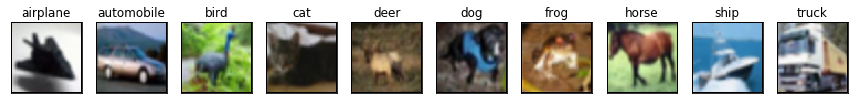

In [3]:
fig = plt.figure(figsize=(15,5))
all_class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

for i in range(num_classes):
    
    # get first image of class i 
    idx = numpy.where(train_labels[:]==i)[0]
    all_images_class_i = train_features[idx]
    im = numpy.transpose(all_images_class_i[0,::], (1, 2, 0))
    
    # plot image
    ax = fig.add_subplot(1, 10, 1 + i, xticks=[], yticks=[])
    ax.set_title(all_class_names[i])
    plt.imshow(im)
    
plt.show()

Again, we need to convert each label to a binary class vector. For instance, an instance with label 1 is mapped to a vector (0,1,0,0,0,0,0,0,0,0). Note that we do *not* rescale the images here anymore; it seems that the network was trained without rescaling as well.

In [4]:
# we do NOT rescale pixel values here
# train_features = train_features.astype('float32') / 255
# test_features = test_features.astype('float32') / 255

# convert each class label to a binary vector
train_labels_categorical = np_utils.to_categorical(train_labels, num_classes)
test_labels_categorical = np_utils.to_categorical(test_labels, num_classes)

We will now load the pretrained VGG16 model. Further, we will append a new dense neural network. Note that we cannot use the old dense network since this was tuned for 1000 classes given in the ImageNet dataset.

In [6]:
from keras import applications
from keras import optimizers

# load pretrained VGG16 model
vgg_model = applications.VGG16(weights='imagenet', 
                           include_top=False, 
                           input_shape=(3, 64, 64))

# define new dense network that we will attach to the pretrained layers of the VGG16 model
# NOTE: This is the same neural network as in the previous notebook; we will also make
# use of the previous weights to initialize this part ...
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
top_model.add(Dense(256))
top_model.add(Activation('relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(128))
top_model.add(Activation('relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))
# make use of previous weights (otherwise, we will do "big" optimization steps at the beginning)
top_model.load_weights("vgg16_top_weights.h5")

# define new model
model = Sequential()

# append all VGG16 layers
for layer in vgg_model.layers: 
    model.add(layer)

# append the new top model
for layer in top_model.layers:
    model.add(layer)
    
# we do not want to retrain the whole new network (very time-consuming!). 
# Instead, we will only fine-tune the last layers ...
for i in range(0, len(model.layers)):
    if i < 15:
        print("%i: Setting layer %s to non-trainable" % (i, str(model.layers[i])))
        model.layers[i].trainable=False
    else:
        print("%i: Keeping layer %s trainable" % (i, str(model.layers[i])))                    
print(model.summary())

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
              metrics=['accuracy'])

C:\Users\Michal\Anaconda3\lib\site-packages\keras\applications\vgg16.py:188: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


0: Setting layer <keras.engine.topology.InputLayer object at 0x000002363FC51F98> to non-trainable
1: Setting layer <keras.layers.convolutional.Conv2D object at 0x000002363FC51FD0> to non-trainable
2: Setting layer <keras.layers.convolutional.Conv2D object at 0x000002363FB50208> to non-trainable
3: Setting layer <keras.layers.pooling.MaxPooling2D object at 0x000002363FC791D0> to non-trainable
4: Setting layer <keras.layers.convolutional.Conv2D object at 0x000002363FC50358> to non-trainable
5: Setting layer <keras.layers.convolutional.Conv2D object at 0x000002363FCB1D30> to non-trainable
6: Setting layer <keras.layers.pooling.MaxPooling2D object at 0x000002363FCBC0F0> to non-trainable
7: Setting layer <keras.layers.convolutional.Conv2D object at 0x000002363FCFC7F0> to non-trainable
8: Setting layer <keras.layers.convolutional.Conv2D object at 0x000002363FD3CE48> to non-trainable
9: Setting layer <keras.layers.convolutional.Conv2D object at 0x000002363FD616A0> to non-trainable
10: Setting

Finally, train fine-tune the network with some data ...

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest',
        )

print("Training model ...")
model_info = model.fit_generator(datagen.flow(train_features, train_labels_categorical, batch_size = 8),
                                 samples_per_epoch = train_features.shape[0], 
                                 nb_epoch = 50, 
                                 validation_data = (test_features, test_labels_categorical), 
                                 verbose=1)


Training model ...


C:\Users\Michal\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\Michal\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=125, epochs=50)`


Epoch 1/50
125/125 [==============================] - 316s 3s/step - loss: 2.1419 - acc: 0.2540 - val_loss: 1.6397 - val_acc: 0.4225
Epoch 2/50
125/125 [==============================] - 315s 3s/step - loss: 2.0088 - acc: 0.3160 - val_loss: 1.8222 - val_acc: 0.3345
Epoch 3/50
125/125 [==============================] - 327s 3s/step - loss: 1.9509 - acc: 0.3000 - val_loss: 1.7505 - val_acc: 0.3600
Epoch 4/50
125/125 [==============================] - 326s 3s/step - loss: 1.7918 - acc: 0.3550 - val_loss: 1.7759 - val_acc: 0.3580
Epoch 5/50
125/125 [==============================] - 319s 3s/step - loss: 1.7252 - acc: 0.3570 - val_loss: 1.5202 - val_acc: 0.4590
Epoch 6/50
125/125 [==============================] - 304s 2s/step - loss: 1.5814 - acc: 0.4470 - val_loss: 1.6111 - val_acc: 0.4680
Epoch 7/50
125/125 [==============================] - 307s 2s/step - loss: 1.7367 - acc: 0.4050 - val_loss: 1.5886 - val_acc: 0.4335
Epoch 8/50
125/125 [==============================] - 297s 2s/step - 

In [ ]:
def plot_model_history(model_history):

    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(numpy.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[0].set_ylim([0,1.0])

    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(numpy.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    axs[1].set_ylim([0,1.1*max(numpy.array(model_history.history['loss']).max(), numpy.array(model_history.history['val_loss']).max())])
    
    plt.show()

def accuracy(test_x, test_y, model):
    
    result = model.predict(test_x)
    predicted_class = numpy.argmax(result, axis=1)
    true_class = numpy.argmax(test_y, axis=1)
    num_correct = numpy.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    
    return (accuracy * 100)

# plot model history
plot_model_history(model_info)

# compute test accuracy
print("Accuracy on test data is: %0.2f" % accuracy(test_features, test_labels_categorical, model))